The purpose of this notebook is to define and test the functions needed for the MODIS class for pre-processing the data. Having explored torchgeo, I have found that the preprocessing must be seperated from the torch work due to limitations on the RasterDataset class. Much of the preprocessing functionality can be taken from the Jupyter Notebooks already written.

Base Class: MODIS dataset <br>
Subclasses: Julian Day and Confidence Level 

Attributes required:<br>
    - 'root': where we can find all of the MODIS files (in practice a CEDA location accessed via JASMIN) - DONE<br>
    <br>
Methods required: <br>
    - extract data: look in root dir and form dataset object from files - DONE <br>
    - crop data: using a shape file, crop the dataset spatially - DONE <br>
    - plot data: create plots for the current dataset - DONE <br>
    - save data: save the altered files back in their tif format so torchgeo is ready to use - TODO<br>
    - binarize data: change all data to zeros/ones only - DONE <br>
    - allow plot to function with binary data - DONE <br>

  
    

Example of how simple preprocessing/graphing will become by using this framework: <br>
```python
# Complete necessary preprocessing operations
modis_data = PP_ModisJD("root dir")
modis_data.populate()
modis_data.crop("shape dir/whole_map.shp", -2)
modis_data.binarize()

# Plot new datasets for insights
modis_data.plot(["202003","202004","202005"], "shape dir/Project_area.shp")

# Preprocessing complete - save tif files to output directory for torchgeo to access independently of raw data
modis_data.extract("target dir")
```

In [1]:
import os
import re
import glob
from datetime import datetime
from calendar import monthrange

import rioxarray as rxr
import xarray as xr
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import fiona

#import shp_utility_functions as suf

### Temp: Copied in shape utility functions (reside in preprocessing folder )

In [2]:
def extract_vertices(shape_file_path):
    """Returns a numpy array of the lat/lons corresponding to the vertices of a polygon defined by a shape file.
    
    Keyword arguments:
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    """
    
    # Extract the vertices using fiona
    with fiona.open(shape_file_path) as shape_data:
        vertices = shape_data[0]['geometry']['coordinates'][0]
        
    # Return them as a numpy array
    return np.array(vertices)
    

def crop_data_spatially(input_data, shape_file_path, zero_remap):
    """Crops input data to keep only the elements within the spatial bounds defined by the input shape file.
    
    Keyword arguments:
    input_data -- DataArray of input data and corresponding x/y (latitude/longitude) coordinates
    shape_file_path -- realtive path where the shp and shx files are located (both required)
    zero_remap -- the new value that elements outside the spatial bounds (but not dropped from the output DataArray)
                  are mapped to after the crop has occurred
    """
    
    # Check that zero_remap is the same type as the values in input_data
    first_element = input_data.item(tuple(np.zeros(len(input_data.shape), int)))
    try:
        if not ((isinstance(zero_remap, (int, np.integer)) and isinstance(first_element, (int, np.integer))) or
                 (isinstance(zero_remap, (float, np.float64)) and isinstance(first_element, (float, np.float64)))):
            raise TypeError('The zero_remap value provided must match the type of the input data:', type(zero_remap), type(input_data.values.dtype)) 
    
    except TypeError as error:
        print(error.args)
    
    
    # Extract the vertice's latitude/longitudes from the shape file
    vertices = extract_vertices(shape_file_path) 
    
    # Define a geometry object to define the polygon
    shape_geometry = [{'type': 'Polygon',
                       'coordinates': [vertices]}]
    
    # Crop the data using the latitude/longitudes and remap the new zero values 
    data_cropped = (input_data-zero_remap).rio.clip(shape_geometry, "epsg:4326") + zero_remap
    return data_cropped


## Base Class Specification 

In [3]:
class PP_ModisFireCCI():
    """Abstract base class for the preprocessing of all MODIS Fire CCI Burned Area datasets. This class should
       not be called directly - instead use the subclass objects.

    `MODIS Fire_cci Burned Area Dataset: <https://geogra.uah.es/fire_cci/firecci51.php>`_
    This dataset was developed by ESA, utilising the MODIS satellite. The dataset contains
    information at both PIXEL (~250m) and GRID (0.25 degrees) resolutions. A variety of 
    useful information is contained within the datasets including Julian Day of burn, 
    confidence level of burn etc.
    For more information, see:
    * `User Guide
      <https://climate.esa.int/media/documents/Fire_cci_D4.2_PUG-MODIS_v1.0.pdf>`_
    """
    
    #: Root directory (in CEDA) where the MODIS files can be found.
    root = None
    
    #: Glob expression used to search for files.
    filename_glob = None
    
    #: Regular expression used to extract date from filename.
    filename_regex = "(?P<date>\d{6})\S{33}(?P<tile_number>\d).*"

    #: Date format string used to parse date from filename.
    date_format = "%Y%m"
    
    #: DataArray used to store the relevant MODIS data.
    data = None
    
    #: Binary flag signifying that data has been mapped to 0/1
    binary_flag = False
    
    
    def __init__(
        self,
        root: str,
    ) -> None:
        """Initialize a new Preprocessing instance.
        Args:
            root: root directory where dataset can be found
        Raises:
            FileNotFoundError: if no files are found in ``root``
        """
        
        # Set the root attribute to that passed into the constructor
        self.root = root
      
    
    def populate(self):
        """Extract the relevant data from the root directory and store it within the object using a DataArray"""
        
        # Populate a list of DataArrays using the seperate files
        dataArrays = []
        pathname = os.path.join(self.root, "**", self.filename_glob)
        filename_regex = re.compile(self.filename_regex, re.VERBOSE)
        
        # For each file found, index the data using the date it corresponds to
        for filepath in glob.iglob(pathname, recursive=True):
            match = re.match(self.filename_regex, os.path.basename(filepath))
            data = rxr.open_rasterio(filepath)
            data = data.assign_coords(date=match.group("date"))
            dataArrays.append(data)
            
        # Finally concatenate the DataArrays and store the result in the object     
        self.data = xr.concat(dataArrays, dim='date')
        
        
    def crop(self, shape_root, zero_remap=0):
        """Crop the whole dataset spatially according to some shape files.
        
        Args:
            shape_root: shape file (.shp) path
            zero_remap: the new value that elements outside the spatial bounds (but not dropped from the output 
                        DataArray) are mapped to after the crop has occurred
                        
        Raises:
            ValueError: if object has not been populated with data before this function is called.
        """
        
        if self.data is None:
            raise ValueError("The data is = None. Try calling 'populate' to assign the object data before making this call.") 

        # Call the relevant utility function 
        self.data = crop_data_spatially(self.data, shape_root, zero_remap)
    
    

## Julian Day Implementation 

In [11]:
class PP_ModisJD(PP_ModisFireCCI):
    """
    Preprocessing class for the burn day (in Julian Days) that a burned area is first seen on.
    
    Possible values (mask not image): 
        -2 = pixel not of burnable type e.g. water, urban areas or permanent snow/ice.
        -1 = pixel not observed in the month (possible cloud cover etc)
         0  = pixel is not burned 
        [1,366] = Julian Day of first detection when the pixel is burned 
    """

    filename_glob = "*JD.tif" 
    
    
    def binarize(self):
        """Maps any data points which are greater than zero to 1.
        
        Raises:
            ValueError: if object has not been populated with data before this function is called.
        """
        
        if self.data is None:
            raise ValueError("The data is = None. Try calling 'populate' to assign the object data before making this call.") 
        
        # If data is more than 0, replace it with 1, otherwise keep original value
        self.data = xr.where(self.data > 0, 1, self.data)
        
        # Set the flag used for plotting functions
        self.binary_flag = True
    
    
    def plot(self, date_list, shape_root = None):
        """Plots the data corresponding to each of the dates listed in date_list.

        Args: 
            date_list: list of dates in the format "YYYYMM" that are requested for plotting
            shape_root: shape file (.shp) path of training area (optional)
        
        Raises:
            ValueError: if object has not been populated with data before this function is called.
        """
        
        if self.data is None:
            raise ValueError("The data is = None. Try calling 'populate' to assign the object data before making this call.") 
        
        
        # Initialise the subplot object
        plt.rcParams.update({'font.size': 13})
        fig, ax = plt.subplots(len(date_list), figsize=(13,10*len(date_list)))
        
        
        for idx, date in enumerate(date_list):
 
            # Want first colours in the map to be: -2 = dark grey, -1 = light grey, 0 = white
            cmaplist1 = plt.cm.gray(np.linspace(0, 1, 4))[1:]
        
            # case: non-binarized data
            if not self.binary_flag:
                
                # Find the first and last Julian Day present in the month requested 
                start_JD = datetime.strptime(date, self.date_format).timetuple().tm_yday
                end_JD = start_JD + monthrange(int(date[:4]), int(date[4:]))[1] -1
                range_JD = end_JD - start_JD

                # Then have a scale of yellow -> orange -> red for the Julian Day of burn days 
                cmaplist2 = plt.cm.YlOrRd(np.linspace(0, 1, range_JD))

                # case: January
                if start_JD == 1:
                    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, cmaplist2)), range_JD+2)
                    bounds = np.linspace(-2.5, end_JD+0.5, range_JD+3)

                # case: February-December
                else:
                    # Want 0-start_JD = black, to signify axis break 
                    cmaplist1 = np.vstack((cmaplist1, np.array([0,0,0,1])))
                    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, cmaplist2)), range_JD+3)
                    bounds = np.concatenate([np.linspace(-2.5, 0.5, 4), np.linspace(start_JD-0.5, end_JD+0.5, range_JD)])

                # Define the ticks for the colour bar
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                ticks = np.concatenate([np.array([-2,-1,0]),np.arange(start_JD,end_JD+1)])
                                 
                # Plot the data
                self.data.sel(date=date).plot(ax=ax[idx], cmap=cmap, norm=norm, cbar_kwargs={'ticks': ticks,'label': 'Julian Day (1 -> 366)'});

            # case: binarized data
            else: 
                bounds = np.linspace(-2.5, 1.5, 5)
                cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', np.vstack((cmaplist1, np.array([1,0,0,0]))), 4)
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                ticks = np.array([-2,-1,0,1])

                self.data.sel(date=date).plot(ax=ax[idx], cmap=cmap, norm=norm, cbar_kwargs={'ticks': ticks,'label': 'Burn Classification'});

                
            # Add remaining components to the graph
            ax[idx].set_title(date[4:] + '/' + date[:4], fontsize=20, fontweight="bold");
            ax[idx].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
            ax[idx].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

            # Optionally add a blue square to illustrate the training area
            if shape_root != None:
                training_coords = extract_vertices(shape_root)
                ax[idx].plot(training_coords[:,0],training_coords[:,1],'--b',linewidth=1);
    
    

In [12]:
test_obj = PP_ModisJD("Modis Data")

In [13]:
test_obj.populate()

In [14]:
test_obj.crop("Shape Files/whole_map.shp", -2)

In [9]:
test_obj.binarize()

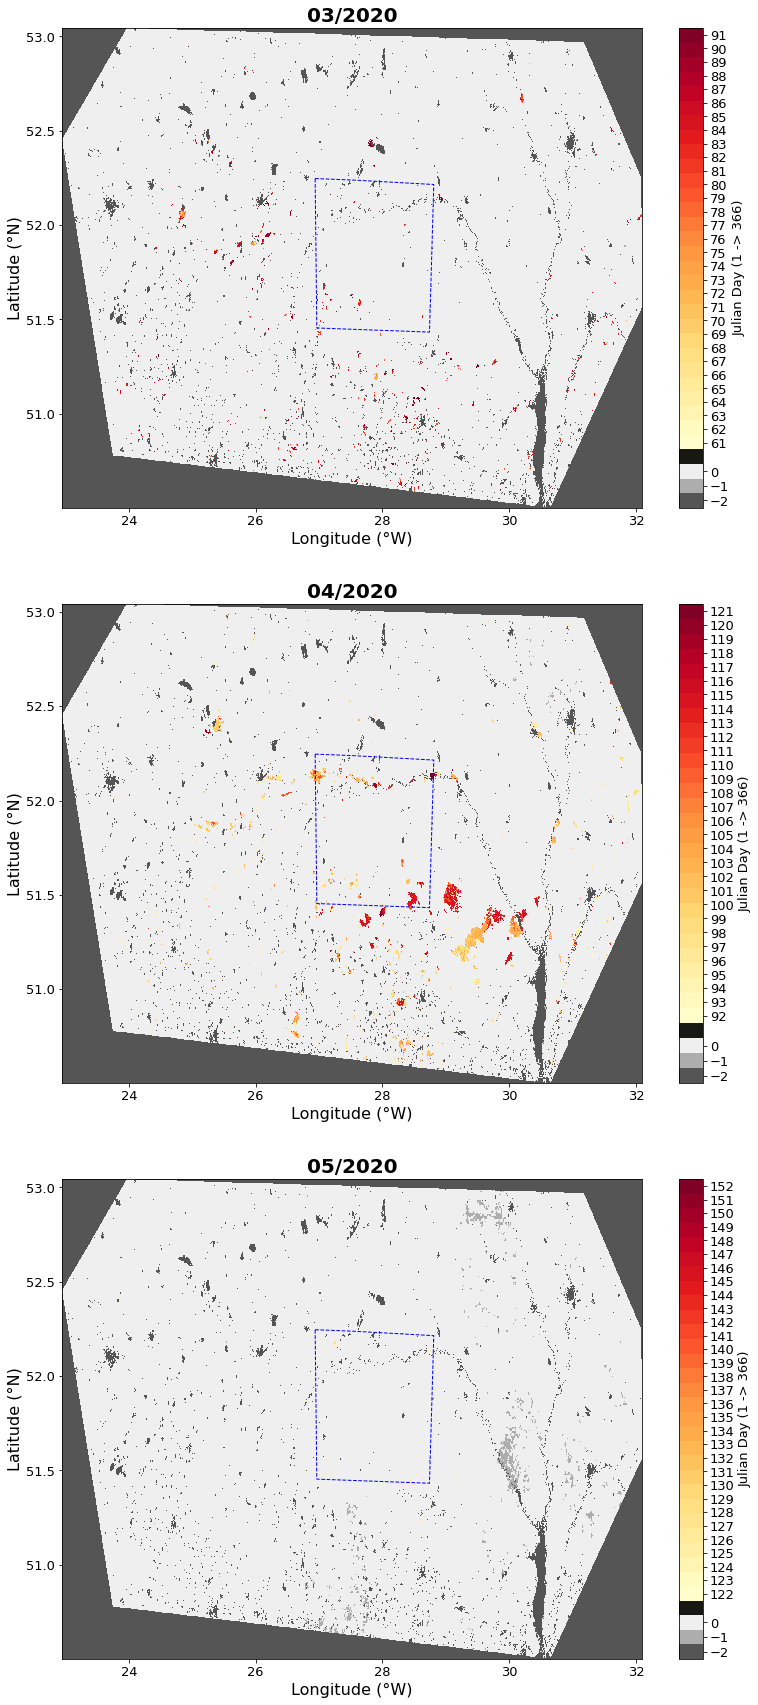

In [15]:
date_list = ["202003","202004","202005"]
test_obj.plot(date_list, "Shape Files/Project_area.shp")

## Confidence Level Implementation 

In [ ]:
class PP_ModisCL(PP_ModisFireCCI):
    """
    Preprocessing class for the confidence level (%) that a burn has occurred in an area.
    
    Possible values (mask not image): 
        0 = pixel is not observed within month or is not burnable.
        1-100 = expression of certainty in burn classification.
        
    """

    filename_glob = "*CL.tif" 
    
    
    def plot(self, date_list, shape_root = None):   
        """Plots the data corresponding to each of the dates listed in date_list.

        Args: 
            date_list: list of dates in the format "YYYYMM" that are requested for plotting
            shape_root: shape file (.shp) path of training area (optional)
        
        Raises:
            ValueError: if object has not been populated with data before this function is called.
        """
        
        if self.data is None:
            raise ValueError("The data is = None. Try calling 'populate' to assign the object data before making this call.") 
        
        # Initialise the subplot object
        plt.rcParams.update({'font.size': 13})
        fig, ax = plt.subplots(len(date_list), figsize=(13,10*len(date_list)))
        ticks = np.arange(0,101,10)
        
        # Prepare the colormap and force 0 -> black 
        cmap = plt.cm.plasma
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmaplist[0] = (0,0,0,1)
        cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
        
        for idx, date in enumerate(date_list):
        
            # Plot the data
            self.data.sel(date=date).plot(ax=ax[idx], cmap=cmap, vmin=0, vmax=100, cbar_kwargs={'ticks': ticks,'label': 'Confidence (%)'});
            ax[idx].set_title(date[4:] + '/' + date[:4], fontsize=20, fontweight="bold");
            ax[idx].set_xlabel('Longitude (\N{DEGREE SIGN}W)',fontsize=16);
            ax[idx].set_ylabel('Latitude (\N{DEGREE SIGN}N)',fontsize=16);

            # Optionally add a white square to illustrate the training area
            if shape_root != None:
                training_coords = extract_vertices(shape_root)
                ax[idx].plot(training_coords[:,0],training_coords[:,1],'--w',linewidth=1.5);
        
        

In [ ]:
test_obj = PP_ModisCL("Modis Data")
test_obj.populate()
test_obj.crop("Shape Files/whole_map.shp")
date_list = ["202003","202004","202005"]
test_obj.plot(date_list, "Shape Files/Project_area.shp")